In [1]:
# GRADER_ONLY
autograded_result = {
    "netid": None,
    "order": [],
    "student_score": 0,
    "total_available": 0,
    "breakdown": {}
}

def record_part(part_name, did_pass, available_points, message=""):
    global autograded_result
    
    # If already graded, remove previous graded order entry for this part
    if part_name in autograded_result["order"]:
        print(f"[Warning] Autograder: {part_name} already graded or a duplicate key exists")
#         autograded_result["order"].remove(part_name)
    
    # Record graded order
    autograded_result["order"].append(part_name)
    
    # Add graded result for this part
    autograded_result["breakdown"][part_name] = {
        "available_points": available_points,
        "points": available_points if did_pass else 0,
        "did_pass": did_pass,
        "message": message,
    }
    
    # Recalculate total_points and total_available points
    autograded_result["student_score"] = 0
    autograded_result["total_available"] = 0
    
    for part_info in autograded_result["breakdown"].values():
        autograded_result["student_score"] += part_info["points"]
        autograded_result["total_available"] += part_info["available_points"]
    
    print(autograded_result)

# Anaylze and Visualize Chicago Uber/Lyft Trips

- 🏆 80 points available
- 🤠 Author: Ye Joo Park (ypark32@illinois.edu)
- ✏️ Last updated on 11/07/2021

![Case Study Cover Image](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/chicago-rideshare-trips-cover-image.jpg?raw=true)

## 💎 Case overview

There have been four Transportation Network Providers (often called rideshare companies 🚗) licensed to operate in Chicago. These rideshare companies are required to routinely report vehicles, drivers, and trips information to the City of Chicago, which are published to the [Chicago Data Portal](https://data.cityofchicago.org/). The latest trips dataset can be downloaded at [this page](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p).

### 🐢 Your dataset

- The original dataset contains information about 170 million ridesharing trips between 2018 and 2021. That translates to over 40GB of raw data. 🙀☠️🙀
- **Approximately 1% of the original data has been randomly sampled**, preprocessed, and compressed.
- Only 2019 and 2020 data have been selected.

### ⚔️ Your goal

Analyze the dataset and answer the following questions:

- 👉 How has the COVID-19 affected the total number of trips in 2019 and 2020?
- 👉 How has the COVID-19 affected the number of monthly trips?
- 👉 Have passengers become more generous or frugal when tipping during the pandemic?
- 👉 What were the trip dimensions (trip duration, distance, and fare) of rides taken place right before the July 4th fireworks in 2019 and 2020?
- 👉 Are passengers pooling rides during the pandemic?
- 👉 What are the top 20 pickup areas (by volume)?
- 👉 What are the average trip total for each of the top 20 pickup area?
- 👉 Is there any area that has a unusally large trip total?

---

▶️ Run the code cell below to import `unittest`, a module used for **🧭 Check Your Work** sections and the autograder.

In [2]:
# DO NOT MODIFY THE CODE IN THIS CELL
import base64
import unittest
tc = unittest.TestCase()

assignment_name = "case-study-03-ridesharing-trips-dataviz"
is_autograder_env = 'record_part' in globals().keys()

if is_autograder_env:
    autograded_result["assignment_name"] = assignment_name

### 🎯 Enter your NetID

- 👇 Fill in the value of `netid` with your **NetID** below.
    - This value will be used by the autograder.

In [3]:
netid = ""

print(f"Your NetID is {netid}.")

Your NetID is .


In [4]:
# GRADER_ONLY
# This code will be stripped to the student-distributed version
netid = "grader_netid"

#### 🧭 Check Your NetID

If the code cell below doesn't throw an error, you're ready to begin this assignment.

In [5]:
# DO NOT CHANGE THE CODE BELOW
tc.assertIsNotNone(netid)
tc.assertIsInstance(netid, str)
tc.assertNotEqual(netid.strip(), "", "Did you forget to enter your NetID?")
tc.assertFalse(netid.strip().isdecimal(), "Did you enter your UIN instead of your NetID?")

if is_autograder_env:
    autograded_result["netid"] = netid

---

### 🔨 Import packages and dataset

▶️ Run the code below to ensure you're using the correct version of plotly.

In [6]:
# Install plotly 5.3.1 using pip
# Colab environment supports pip
if 'google.colab' in str(get_ipython()):
    !pip install plotly==5.3.1

# If you're using conda, use the code below
# !conda install -c plotly plotly=5.3.1

▶️ Run the code cell below to import packages used in the case.

In [7]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go

# plotly.io is a low-level interface for interacting with figures/
# plotly.io.templates lists available plotly templates
# https://plotly.com/python-api-reference/plotly.io.html
import plotly.io as pio

pd.set_option('display.max_columns', 50)

#### 🧭 Check Plotly Version

Run the code below to ensure that your notebook uses the same Plotly version as the autograder.

In [8]:
# DO NOT CHANGE THE CODE IN THIS CELL
print(f'The current plotly version is {plotly.__version__}')
tc.assertTrue(plotly.__version__.startswith('5.3'), 'Your plotly version should be 5.3.x')

The current plotly version is 5.3.1


▶️ Run the code below to import and process the trips dataset.

In [9]:
df = pd.read_csv(
    'https://github.com/bdi475/datasets/raw/main/case-studies/chicago-ridesharing/chicago-ridesharing-trips-2019-2020.csv.gz',
    compression='gzip',
    parse_dates=['start']
)
df_community_areas = pd.read_csv('https://github.com/bdi475/datasets/raw/main/case-studies/chicago-ridesharing/chicago-community-area-numbers.csv')

# Replace community area numbers with area names
df = df.merge(df_community_areas, left_on='pickup_area', right_on='area_number', how='left')
df['pickup_area'] = df['community'].copy()
df.drop(columns=['community', 'area_number'], inplace=True)

df = df.merge(df_community_areas, left_on='dropoff_area', right_on='area_number', how='left')
df['dropoff_area'] = df['community'].copy()
df.drop(columns=['community', 'area_number'], inplace=True)

# Create a copy for 🧭 Check Your Work section
df_backup = df.copy()

---

## 📐 Part 1: Data overview

---

### 🎯 Deliverable 1: First 5 rows

#### 👇 Tasks

- ✔️ Display the first 5 rows of `df` using `.head()`.

#### 🚀 Hint

```python
my_dataframe.head()
```

In [10]:
# YOUR CODE BEGINS
df.head(5)
# YOUR CODE ENDS

start  trip_seconds  trip_miles      pickup_area     dropoff_area  \
0 2019-01-01           303         1.4   Garfield Ridge         Clearing   
1 2019-01-01           697         3.0  Near North Side   Near West Side   
2 2019-01-01          1598         4.7     Lincoln Park             Loop   
3 2019-01-01           573         0.9  Near North Side  Near North Side   
4 2019-01-01          1562         2.4  Near North Side  Near North Side   

   fare  tip  additional_charges  trip_total  shared_trip_authorized  \
0   5.0  5.0                7.68       17.68                   False   
1   7.5  0.0                2.50       10.00                   False   
2  10.0  2.0                2.50       14.50                   False   
3   5.0  0.0                2.50        7.50                   False   
4  10.0  0.0                2.50       12.50                   False   

   trips_pooled  pickup_lat  pickup_lon  dropoff_lat  dropoff_lon  
0             1   41.792592  -87.769615    41.779583   -87.768511  
1             1   41.892073  -87.628874    41.885300   -87.642808  
2             1   41.922083  -87.634156    41.870607   -87.622173  
3             1   41.892042  -87.631864    41.892508   -87.626215  
4             1   41.900221  -87.629105    41.895033   -87.619711

#### 🧭 Check your work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [11]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-01"
did_pass = True
available_points = 2
message = ""

try:
    pass
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01'], 'student_score': 2, 'total_available': 2, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

### 🎯 Deliverable 2: Summary of DataFrame

#### 👇 Tasks

- ✔️ Print a concise summary of `df` using `.info()`.

#### 🚀 Hint

```python
my_dataframe.info()
```

In [12]:
# YOUR CODE BEGINS
df.info()
# YOUR CODE ENDS

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388193 entries, 0 to 1388192
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   start                   1388193 non-null  datetime64[ns]
 1   trip_seconds            1388193 non-null  int64         
 2   trip_miles              1388193 non-null  float64       
 3   pickup_area             1388193 non-null  object        
 4   dropoff_area            1388193 non-null  object        
 5   fare                    1388193 non-null  float64       
 6   tip                     1388193 non-null  float64       
 7   additional_charges      1388193 non-null  float64       
 8   trip_total              1388193 non-null  float64       
 9   shared_trip_authorized  1388193 non-null  bool          
 10  trips_pooled            1388193 non-null  int64         
 11  pickup_lat              1388193 non-null  float64       
 12  pickup_lon    

In [13]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-02"
did_pass = True
available_points = 2
message = ""

try:
    pass
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02'], 'student_score': 4, 'total_available': 4, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

### 🎯 Deliverable 3: Number of rows and columns in the dataset

#### 👇 Tasks

- ✔️ Store the number of rows in `df` to a new variable named `num_rows`.
- ✔️ Store the number of columns in `df` to a new variable named `num_cols`.
- ✔️ Both `num_rows` and `num_cols` must be `int`s.
- ✔️ Use `.shape`, not `len()`.

In [14]:
# YOUR CODE BEGINS
num_rows = df.shape[0]
num_cols = df.shape[1]
# YOUR CODE ENDS

print(f'There are {num_rows} rows and {num_cols} columns in the dataset.')

There are 1388193 rows and 15 columns in the dataset.


#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [15]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-03"
did_pass = True
available_points = 2
message = ""

try:
    tc.assertEqual(num_rows, len(df_backup.index), f'Number of rows should be {len(df_backup.index)}')
    tc.assertEqual(num_cols, len(df_backup.columns), f'Number of columns should be {len(df_backup.columns)}')
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03'], 'student_score': 6, 'total_available': 6, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

## 🗓️ Part 2: Extract datetime values into separate columns

The `start` column contains trip start timestamps. In this part of the case study, you will extract year, month, day of the month, day of the week, hour, and weekday/weekend information into separate columns.

---

### 🎯 Deliverable 4: Extract year into a new column

▶️ Run the code below to print the first 3 values of the `start` column and the data types.

In [16]:
display(df['start'].head(3))
print('=================================================')
print(f"df['start'] column's data type is {df['start'].dtype}.")

0   2019-01-01
1   2019-01-01
2   2019-01-01
Name: start, dtype: datetime64[ns]

df['start'] column's data type is datetime64[ns].


#### 👇 Tasks

- ✔️ From `df`, extract the year (e.g., `2019`, `2020`) from the `start` column and store it to a new column named `year`.
- ✔️ We will provide you the fully-working code below.

#### 🔥 Solution

![Code](https://github.com/bdi475/images/blob/98064711bd159e2712ceb4c4ec7226fd7520d274/case-studies/rideshare-trips/code-extract-year-01.png?raw=true)

👆 `date_series.dt` is an accessor object datetimelike Series values. You can refer to the [documentation here](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html).

In [17]:
# YOUR CODE BEGINS
df['year'] = df['start'].dt.year
# YOUR CODE ENDS

display(df[['start', 'year']].sample(5))

start  year
491424  2019-07-02 11:00:00  2019
9852    2019-01-05 13:15:00  2019
1036018 2020-01-29 14:15:00  2020
372753  2019-05-18 15:15:00  2019
620176  2019-08-20 20:00:00  2019

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [18]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-04"
did_pass = True
available_points = 2
message = ""

try:
    df_backup['year'] = df_backup['start'].dt.year

    tc.assertEqual(df.shape, df_backup.shape, 'Incorrect number of rows and/or columns')
    pd.testing.assert_frame_equal(
        df[['start', 'year']].sort_values('start').reset_index(drop=True),
        df_backup[['start', 'year']].sort_values('start').reset_index(drop=True),
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04'], 'student_score': 8, 'total_available': 8, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

### 🎯 Deliverable 5: Extract month, day of month, day of week, and hour into columns

#### 👇 Tasks

- ✔️ Similar to the previous deliverable, extract the month, day of month, day of week, and hour of each start time in `df` to new columns.
- ✔️ Use the following column names. Sample values are also given.
    - `month`: `1`, `2`, ..., `11`, `12`
    - `day`: `1`, `2`, ..., `28`, `29`, `30`, `31`
    - `dayofweek`: `0` for Monday, `6` for Sunday
    - `hour`: `0`, `1`, ..., `22`, `23`

In [19]:
# YOUR CODE BEGINS
df['month'] = df['start'].dt.month
df['day'] = df['start'].dt.day
df['dayofweek'] = df['start'].dt.dayofweek
df['hour'] = df['start'].dt.hour
# YOUR CODE ENDS

display(df[['start', 'month', 'day', 'dayofweek', 'hour']].sample(5))

start  month  day  dayofweek  hour
681497  2019-09-14 11:45:00      9   14          5    11
378421  2019-05-20 13:30:00      5   20          0    13
710541  2019-09-25 17:00:00      9   25          2    17
1360766 2020-11-28 13:15:00     11   28          5    13
522507  2019-07-14 14:00:00      7   14          6    14

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [20]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-05"
did_pass = True
available_points = 4
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfYmFja3VwWydtb250aCddID0gZGZfYmFja3VwWydzd\
    GFydCddLmR0Lm1vbnRoCmRmX2JhY2t1cFsnZGF5J10gPSBkZl9iYWNrdXBbJ3N0YXJ0J10uZHQuZG\
    F5CmRmX2JhY2t1cFsnZGF5b2Z3ZWVrJ10gPSBkZl9iYWNrdXBbJ3N0YXJ0J10uZHQuZGF5b2Z3ZWV\
    rCmRmX2JhY2t1cFsnaG91ciddID0gZGZfYmFja3VwWydzdGFydCddLmR0LmhvdXI=')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(df.shape, df_backup.shape, 'Incorrect number of rows and/or columns')
    pd.testing.assert_frame_equal(
        df[['start', 'month', 'day', 'dayofweek', 'hour']].sort_values('start').reset_index(drop=True),
        df_backup[['start', 'month', 'day', 'dayofweek', 'hour']].sort_values('start').reset_index(drop=True),
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05'], 'student_score': 12, 'total_available': 12, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

### 🎯 Deliverable 6: Create `weekday_weekend` column

#### 👇 Tasks

- ✔️ Assume Mondays-Thursdays are weekdays and Fridays-Sundays are weekends.
- ✔️ Create a new column named `weekday_weekend` in `df`.
- ✔️ For each row, the value of `weekday_weekend` will either be string `'weekday'` or string `'weekend'` (case-sensitive) based on the value of the `dayofweek` column.
    - `'weekday'` if `dayofweek` is less than or equal to `3` (`0` == Monday, `1` == Tuesday, `2` == Wednesday, `3` == Thursday)
    - `'weekend'` if otherwise (`4` == Friday, `5` == Saturday, `6` == Sunday)

#### 🚀 Hint

There are many ways to achieve this task.

The code below creates a new column named `cheap_expensive` where the value will be string `'cheap'` if the price is less than or equal to `10` and `'expensive'` if otherwise.

```python
my_dataframe['cheap_expensive'] = np.where(my_dataframe['price'] <= 10, 'cheap', 'expensive')
```

In [21]:
# YOUR CODE BEGINS
df['weekday_weekend'] = np.where(df['dayofweek'] <= 3, 'weekday', 'weekend')
# YOUR CODE ENDS

display(df[['dayofweek', 'weekday_weekend']].sample(5))

dayofweek weekday_weekend
400722           2         weekday
1158969          0         weekday
773554           5         weekend
724987           0         weekday
796975           6         weekend

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [22]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-06"
did_pass = True
available_points = 3
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfYmFja3VwWyd3ZWVrZGF5X3dlZWtlbmQnXSA9IG5wL\
    ndoZXJlKGRmX2JhY2t1cFsnZGF5b2Z3ZWVrJ10gPD0gMywgJ3dlZWtkYXknLCAnd2Vla2VuZCcp')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(df.shape, df_backup.shape, 'Incorrect number of rows and/or columns')
    pd.testing.assert_frame_equal(
        df[['start', 'dayofweek', 'weekday_weekend']].sort_values('start').reset_index(drop=True),
        df_backup[['start', 'dayofweek', 'weekday_weekend']].sort_values('start').reset_index(drop=True),
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06'], 'student_score': 15, 'total_available': 15, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

## 😷 Part 3: Visualize the effects of COVID-19 on the volume of ridesharing trips

Although the first case of COVID-19 was reported in January 2020 in the United States, people started to take it seriously in March 2020.

How did COVID-19 affect the volume of ridesharing trips? 💨 Let's visualize and compare the monthly number of trips for both 2019 and 2020.

---

### 🎯 Deliverable 7: Total number of trips in 2019 and 2020

#### 👇 Tasks

- ✔️ Using `df`, count the number of trips made in 2019 and store the number to a new variable named `num_2019_trips`.
- ✔️ Using `df`, count the number of trips made in 2020 and store the number to a new variable named `num_2020_trips`.

#### 🚀 Hint

For `num_2019_trips`, retrieve the number of rows where `df['year']` is `2019`.

In [23]:
# YOUR CODE BEGINS
num_2019_trips = (df['year'] == 2019).sum()
num_2020_trips = (df['year'] == 2020).sum()
# YOUR CODE ENDS

print(f'There were {num_2019_trips} trips in 2019.')
print(f'There were {num_2020_trips} trips in 2020.')
print(f'The number of trips decreased by {(num_2019_trips - num_2020_trips) / num_2019_trips * 100:.1f}%.')

There were 966346 trips in 2019.
There were 421847 trips in 2020.
The number of trips decreased by 56.3%.


#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [24]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-07"
did_pass = True
available_points = 3
message = ""

try:
    decoded_code = base64.b64decode(b'bnVtXzIwMTlfdHJpcHNfY2hlY2sgPSBkZ\
    l9iYWNrdXBbJ3llYXInXS52YWx1ZV9jb3VudHMoKS5sb2NbMjAxOV0KbnVtXzIwMjBf\
    dHJpcHNfY2hlY2sgPSBkZl9iYWNrdXBbJ3llYXInXS52YWx1ZV9jb3VudHMoKS5sb2NbMjAyMF0=')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(num_2019_trips, num_2019_trips_check,
                   f"Incorrect number of 2019 trips, should be {num_2019_trips_check}")
    tc.assertEqual(num_2020_trips, num_2020_trips_check,
                   f"Incorrect number of 2020 trips, should be {num_2020_trips_check}")
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07'], 'student_score': 18, 'total_available': 18, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-trips-dataviz'}


---

### 🎯 Deliverable 8: Monthly number of trips and tip percentage

#### 👇 Tasks

- ✔️ Using `df`, calculate the number of monthly trips and average tip percentages.
- ✔️ Use the code given below.

![Code](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/code-monthly-trips-and-tip-pct-01.png?raw=true)

In [25]:
# YOUR CODE BEGINS
df_monthly = df.groupby(['year', 'month'], as_index=False).agg({
    'start': 'count',
    'tip': 'sum',
    'fare': 'sum',
}).rename(columns={
    'start': 'num_trips'
})

# Calculate average tip %
df_monthly['tip_pct'] = df_monthly['tip'] / df_monthly['fare']

# Remove tip and fare columns since they're not needed anymore
df_monthly.drop(columns=['tip', 'fare'], inplace=True)
# YOUR CODE ENDS

display(df_monthly)

year  month  num_trips   tip_pct
0   2019      1      77313  0.048254
1   2019      2      77374  0.045353
2   2019      3      89688  0.047561
3   2019      4      79829  0.047786
4   2019      5      84168  0.049438
5   2019      6      80349  0.052670
6   2019      7      79007  0.055360
7   2019      8      81141  0.056450
8   2019      9      76516  0.058380
9   2019     10      82129  0.056311
10  2019     11      79395  0.052962
11  2019     12      79437  0.054570
12  2020      1      76255  0.052041
13  2020      2      78726  0.050506
14  2020      3      45565  0.045580
15  2020      4      12612  0.028806
16  2020      5      15618  0.037591
17  2020      6      22092  0.046910
18  2020      7      28129  0.042972
19  2020      8      29010  0.037146
20  2020      9      30265  0.040097
21  2020     10      33488  0.040802
22  2020     11      24501  0.040884
23  2020     12      25586  0.040130

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [26]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-08"
did_pass = True
available_points = 2
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfbW9udGhseV9jaGVjayA9IGRmX2JhY2t1cC5ncm91\
    cGJ5KFsneWVhcicsICdtb250aCddLCBhc19pbmRleD1GYWxzZSkuYWdnKHsKICAgICdzdGFydCc6IC\
    djb3VudCcsCiAgICAndGlwJzogJ3N1bScsCiAgICAnZmFyZSc6ICdzdW0nLAp9KS5yZW5hbWUoY29s\
    dW1ucz17CiAgICAnc3RhcnQnOiAnbnVtX3RyaXBzJwp9KQoKZGZfbW9udGhseV9jaGVja1sndGlwX3\
    BjdCddID0gZGZfbW9udGhseV9jaGVja1sndGlwJ10gLyBkZl9tb250aGx5X2NoZWNrWydmYXJlJ10K\
    ZGZfbW9udGhseV9jaGVjay5kcm9wKGNvbHVtbnM9Wyd0aXAnLCAnZmFyZSddLCBpbnBsYWNlPVRydWUp')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(df_monthly.shape, df_monthly_check.shape, 'Incorrect number of rows and/or columns')
    pd.testing.assert_frame_equal(
        df_monthly.sort_values(['year', 'month']).reset_index(drop=True),
        df_monthly_check.sort_values(['year', 'month']).reset_index(drop=True),
        check_like=True
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08'], 'student_score': 20, 'total_available': 20, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}}, 'assignment_name': 'case-study-03-ridesharing-tr

---

### 🎯 Deliverable 9: Sunburst Chart of Monthly Trips

#### 👇 Tasks

- ✔️ Using `df_monthly`, create a sunburst chart that shows the proportion of monthly number of trips for both 2019 and 2020.
- ✔️ Set an appropriate title.
- ✔️ Set both the `width` and `height` to `600`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/3a8d245f873b4cd03e4053bc0a827591562740f5/case-studies/rideshare-trips/sample-output-trips-monthly-breakdown-sunburst-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, and `...`s with your own values from the code below.

```python
fig = px.sunburst(
    my_dataframe,
    path=['column1', 'column2'],
    values='column3',
    title='Your Title Here',
    width=...,
    height=...
)
fig.show()
```

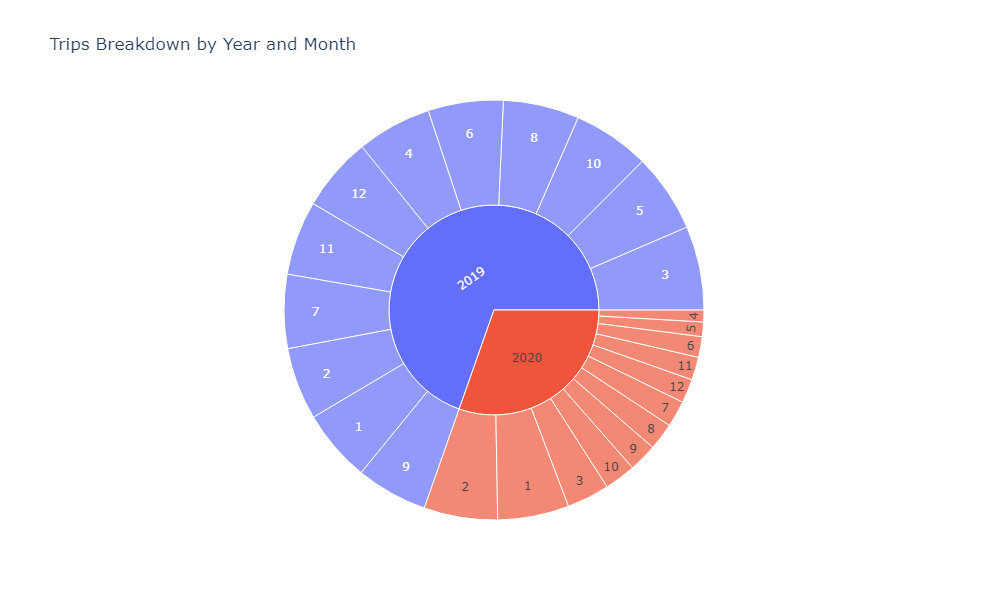

In [27]:
# YOUR CODE BEGINS
fig = px.sunburst(
    df_monthly,
    path=['year', 'month'],
    values='num_trips',
    title='Trips Breakdown by Year and Month',
    width=600,
    height=600
)

fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [28]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-09"
did_pass = True
available_points = 3
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(fig.data[0].type, 'sunburst', 'Must be a sunburst chart')
    tc.assertEqual(fig.layout.width, 600, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 600, 'Incorrect height')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguc3VuYnVyc3QoCiAgICBkZ\
    l9tb250aGx5X2NoZWNrLAogICAgcGF0aD1bJ3llYXInLCAnbW9udGgnXSwKICAgIHZhbHVlcz0n\
    bnVtX3RyaXBzJywKICAgIHRpdGxlPSdUcmlwcyBCcmVha2Rvd24gYnkgWWVhciBhbmQgTW9udGg\
    nLAogICAgd2lkdGg9NjAwLAogICAgaGVpZ2h0PTYwMAop')
    eval(compile(decoded_code, '<string>', 'exec'))

    np.testing.assert_array_equal(
        fig.data[0].labels,
        fig_check.data[0].labels,
        'Label(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].parents,
        fig_check.data[0].parents,
        'Parent(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].values,
        fig_check.data[0].values,
        'Value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09'], 'student_score': 23, 'total_available': 23, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-09': {'available_p

---

### 🎯 Deliverable 10: Monthly number of trips in 2019 and 2020 (facet grid bar chart)

#### 👇 Tasks

- ✔️ Using `df_monthly`, create two bar charts side-by-side within a same figure showing the number of monthly trips for 2019 and 2020.
    - You will have to use a *facet grid* that we haven't covered in lectures.
    - A facet grid is a group of plots within one figure categorized by 1 or 2 criteria.
    - This deliverable expects you to do some research on your own, although the hint will provide majority of the code required to complete this task.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set the `width` to `1000` and `height` to `500`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/9d445502c9cab44dd4ad57fcd3a181d14dba42b5/case-studies/rideshare-trips/sample-output-monthly-number-of-trips-facet-grid-bar-charts-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, and `...`s with your own values from the code below.

```python
fig = px.bar(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    facet_col='column3',
    width=...,
    height=...,
    template='plotly_dark',
    color='num_trips',
    color_continuous_scale=['White', 'Yellow']
)
fig.show()
```

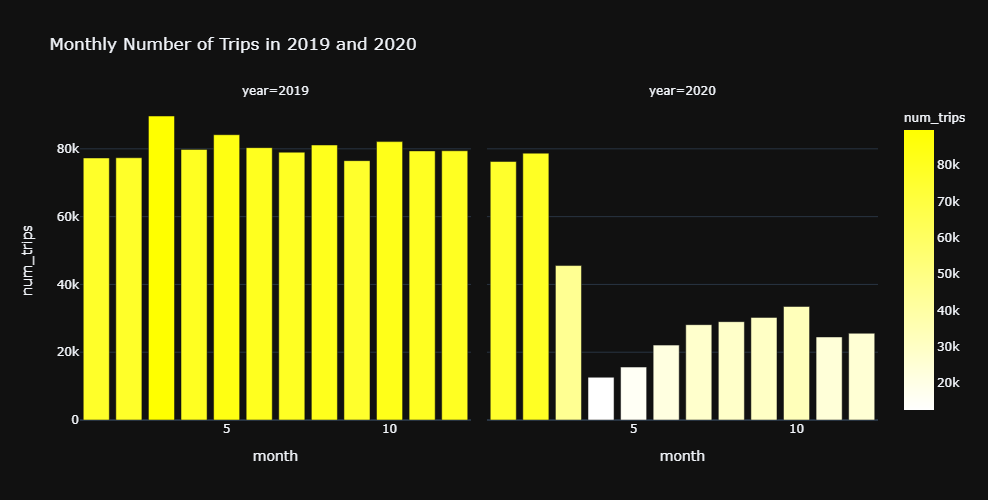

In [29]:
# YOUR CODE BEGINS
fig = px.bar(
    df_monthly,
    title='Monthly Number of Trips in 2019 and 2020',
    x='month',
    y='num_trips',
    facet_col='year',
    width=1000,
    height=500,
    template='plotly_dark',
    color='num_trips',
    color_continuous_scale=['White', 'Yellow']
)
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [30]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-10"
did_pass = True
available_points = 5
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), 2, 'Must use a facet grid to display two bar charts side-by-side')
    tc.assertEqual(fig.layout.width, 1000, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 500, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguYmFyKAogICAgZGZfbW9udGhseV9jaGV\
    jaywKICAgIHRpdGxlPSdNb250aGx5IE51bWJlciBvZiBUcmlwcyBpbiAyMDE5IGFuZCAyMDIwJywKICAgIHg9\
    J21vbnRoJywKICAgIHk9J251bV90cmlwcycsCiAgICBmYWNldF9jb2w9J3llYXInLAogICAgd2lkdGg9MTAwM\
    CwKICAgIGhlaWdodD01MDAsCiAgICB0ZW1wbGF0ZT0ncGxvdGx5X2RhcmsnLAogICAgY29sb3I9J251bV90cm\
    lwcycsCiAgICBjb2xvcl9jb250aW51b3VzX3NjYWxlPVsnV2hpdGUnLCAnWWVsbG93J10KKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    for i in range(len(fig_check.data)):
        tc.assertEqual(fig.data[i].type, 'bar', 'Must be a bar chart')
        tc.assertEqual(fig.data[i].orientation, 'v', 'Must be a vertical bar chart')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10'], 'student_score': 28, 'total_available': 28, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-

---

### 🎯 Deliverable 11: Monthly number of trips in 2019 and 2020 (line plot)

#### 👇 Tasks

- ✔️ Using `df_monthly`, create a line plot of monthly number of trips.
    - Use `year` to create two separate lines (encoded by different colors) for 2019 and 2020.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set the `width` to `800` and `height` to `500`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/2a9d2cccfb583a83a16fa4938e6fed2f437ca56c/case-studies/rideshare-trips/sample-monthly-number-of-trips-annual-comparison-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, and `...`s with your own values from the code below.

```python
fig = px.line(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    color='column3',
    template='plotly_dark',
    width=...,
    height=...
)
fig.show()
```

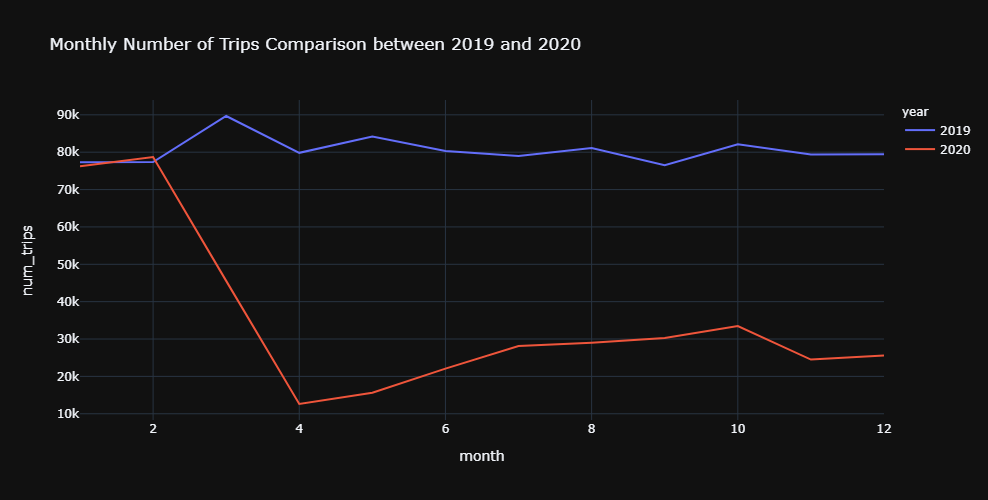

In [31]:
# YOUR CODE BEGINS
fig = px.line(
    df_monthly,
    title='Monthly Number of Trips Comparison between 2019 and 2020',
    x='month',
    y='num_trips',
    color='year',
    template='plotly_dark',
    width=800,
    height=500
)

fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [32]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-11"
did_pass = True
available_points = 4
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), df_monthly_check['year'].nunique(), 'Must encode each year with different colors')
    tc.assertEqual(fig.layout.width, 800, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 500, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHgubGluZSgKICAgIG\
    RmX21vbnRobHlfY2hlY2ssCiAgICB0aXRsZT0nTW9udGhseSBOdW1iZXIgb2YgVHJpcH\
    MgQ29tcGFyaXNvbiBiZXR3ZWVuIDIwMTkgYW5kIDIwMjAnLAogICAgeD0nbW9udGgnLA\
    ogICAgeT0nbnVtX3RyaXBzJywKICAgIGNvbG9yPSd5ZWFyJywKICAgIHRlbXBsYXRlPS\
    dwbG90bHlfZGFyaycsCiAgICB3aWR0aD04MDAsCiAgICBoZWlnaHQ9NTAwCik=')
    eval(compile(decoded_code, '<string>', 'exec'))

    for i in range(len(fig_check.data)):
        # In plotly, a line plot is a scatter plot with lines connecting the dots
        tc.assertEqual(fig.data[i].type, 'scatter', 'Must be a line plot')
        tc.assertIsNotNone(fig_check.data[i].line.color, 'Must be a line plot')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11'], 'student_score': 32, 'total_available': 32, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': 

---

### 📌 Interpreting the pre-covid vs post-covid monthly number of trips

- 🔍 In March 2020, the number of trips have plummeted due to the widespread outbreak of COVID-19.
- 🔍 April 2020 was the worst month for ridesharing drivers.
- 🔍 The number of trips have slowly increased from April to October.
- 🔍 In November 2020, continued surge in the number of COVID-19 cases has caused the number of trips to go down again.

---

## 💵 Part 4: Visualize the effect of COVID-19 on tips

Did passengers tip more on average during the pandemic since they appreciated the drivers providing services during risky times?

Or did the passengers tip less on average since the pandemic has devastated the nation's economy in 2020?

---

### 🎯 Deliverable 12: Monthly average tip percentages in 2019 and 2020 (facet grid bar chart)

#### 👇 Tasks

- ✔️ Using `df_monthly`, create two bar charts side-by-side within a same figure showing the monthly average tip percentages in 2019 and 2020.
    - `tip_pct` column in `df_monthly` contains the monthly average tip percentages.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set the `width` to `1000` and `height` to `500`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/e45e52eae6f7ffa239e1a381f1633e01364cbfb8/case-studies/rideshare-trips/sample-monthly-average-tip-pct-facet-grid-bar-charts-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, and `...`s with your own values from the code below.

```python
fig = px.bar(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    facet_col='column3',
    width=...,
    height=...,
    template='plotly_dark',
    color='tip_pct',
    color_continuous_scale=['White', 'GreenYellow']
)
fig.update_layout(yaxis_tickformat='%')
fig.update_layout(yaxis2_tickformat='%')
fig.show()
```

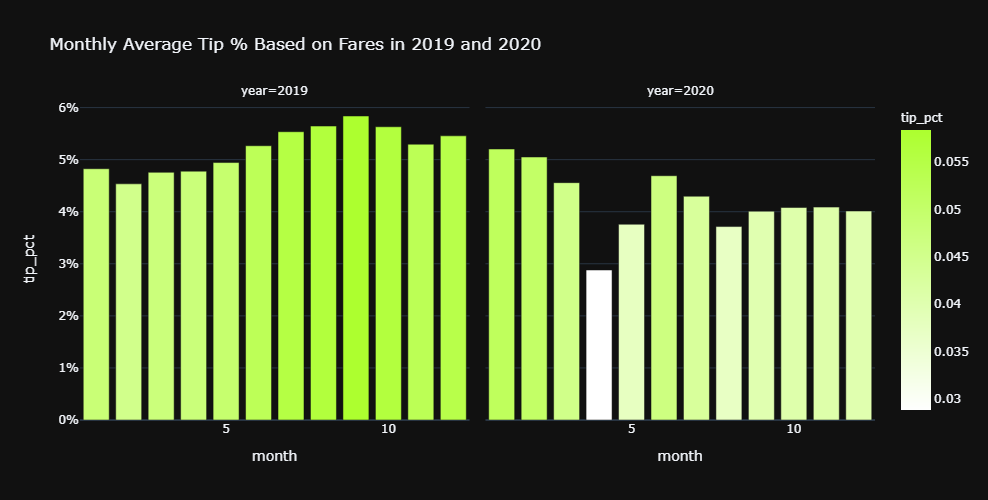

In [33]:
# YOUR CODE BEGINS
fig = px.bar(
    df_monthly,
    title='Monthly Average Tip % Based on Fares in 2019 and 2020',
    x='month',
    y='tip_pct',
    facet_col='year',
    width=1000,
    height=500,
    template='plotly_dark',
    color='tip_pct',
    color_continuous_scale=['White', 'GreenYellow']
)
fig.update_layout(yaxis_tickformat='%')
fig.update_layout(yaxis2_tickformat='%')
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [34]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-12"
did_pass = True
available_points = 5
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), 2, 'Must use a facet grid to display two bar charts side-by-side')
    tc.assertEqual(fig.layout.width, 1000, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 500, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguYmFyKAogICAgZGZfbW9udGhseV9\
    jaGVjaywKICAgIHRpdGxlPSdNb250aGx5IEF2ZXJhZ2UgVGlwICUgQmFzZWQgb24gRmFyZXMgaW4gMjAx\
    OSBhbmQgMjAyMCcsCiAgICB4PSdtb250aCcsCiAgICB5PSd0aXBfcGN0JywKICAgIGZhY2V0X2NvbD0ne\
    WVhcicsCiAgICB3aWR0aD0xMDAwLAogICAgaGVpZ2h0PTUwMCwKICAgIHRlbXBsYXRlPSdwbG90bHlfZG\
    FyaycsCiAgICBjb2xvcj0ndGlwX3BjdCcsCiAgICBjb2xvcl9jb250aW51b3VzX3NjYWxlPVsnV2hpdGU\
    nLCAnR3JlZW5ZZWxsb3cnXQop')
    eval(compile(decoded_code, '<string>', 'exec'))

    for i in range(len(fig_check.data)):
        tc.assertEqual(fig.data[i].type, 'bar', 'Must be a bar chart')
        tc.assertEqual(fig.data[i].orientation, 'v', 'Must be a vertical bar chart')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12'], 'student_score': 37, 'total_available': 37, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'points': 2, 'did_pass':

---

### 🎯 Deliverable 13: Monthly average tip percentages in 2019 and 2020

#### 👇 Tasks

- ✔️ Using `df_monthly`, create a line plot of monthly average tip percentages.
    - Use `year` to create two separate lines (encoded by different colors) for 2019 and 2020.
    - `tip_pct` column in `df_monthly` contains the monthly average tip percentages.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set the `width` to `800` and `height` to `500`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/4eb3edd8edc77b080d8ba29137bbc29db081e8c3/case-studies/rideshare-trips/sample-monthly-average-tip-pct-line-plot-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, and `...`s with your own values from the code below.

```python
fig = px.line(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    color='column3',
    template='plotly_dark',
    width=...,
    height=...
)
fig.update_layout(yaxis_tickformat='%')
fig.show()
```

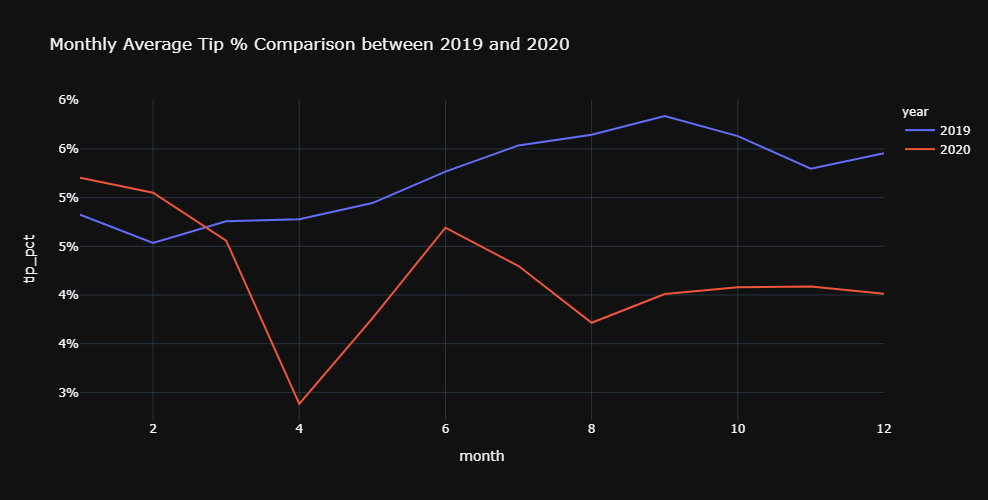

In [35]:
# YOUR CODE BEGINS
fig = px.line(
    df_monthly,
    title='Monthly Average Tip % Comparison between 2019 and 2020',
    x='month',
    y='tip_pct',
    color='year',
    template='plotly_dark',
    width=800,
    height=500
)
fig.update_layout(yaxis_tickformat='%')
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [36]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-13"
did_pass = True
available_points = 4
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), df_monthly_check['year'].nunique(), 'Must encode each year with different colors')
    tc.assertEqual(fig.layout.width, 800, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 500, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHgubGluZSgKICAgIGRmX21vbnRob\
    HlfY2hlY2ssCiAgICB0aXRsZT0nTW9udGhseSBBdmVyYWdlIFRpcCAlIENvbXBhcmlzb24gYmV0d2Vl\
    biAyMDE5IGFuZCAyMDIwJywKICAgIHg9J21vbnRoJywKICAgIHk9J3RpcF9wY3QnLAogICAgY29sb3I\
    9J3llYXInLAogICAgdGVtcGxhdGU9J3Bsb3RseV9kYXJrJywKICAgIHdpZHRoPTgwMCwKICAgIGhlaWdodD01MDAKKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    for i in range(len(fig_check.data)):
        # In plotly, a line plot is a scatter plot with lines connecting the dots
        tc.assertEqual(fig.data[i].type, 'scatter', 'Must be a line plot')
        tc.assertIsNotNone(fig_check.data[i].line.color, 'Must be a line plot')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13'], 'student_score': 41, 'total_available': 41, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_points': 2, 'point

---

### 📌 Interpreting the pre-covid vs post-covid average percentage of tips

- 🔍 Passengers tipped less after the COVID-19 outbreak.
- 🔍 Possible explanations:
    - COVID-19 has caused an economic downturn.
    - Many people have also lost jobs during this period.
    - COVID-19 may have prevented the driver and the passenger(s) from having a conversation. Less conversation could result in less tips.

---

## ✨ Part 5: Trips right before July 4th fireworks

Every July 4th, massive crowds gather around places (or boats) to view the fireworks. How did July 4th become the "national fireworks day"? July 4, 1776 is considered to be the birth of United States of Amercia as an independent nation. The Continental Congress approved the final wording of the Declaration of Independence on July 4, 1776. The first-ever recorded July 4th fireworks celebration was held in Philadelphia on July 4, 1777. Since then, there hasn't been an Independence Day without a firework. 💥💥 

[[Source 1]](https://www.constitutionfacts.com/us-declaration-of-independence/fourth-of-july/#:~:text=We%20celebrate%20American%20Independence%20Day,America%20as%20an%20independent%20nation.) [[Source 2]](https://www.bhg.com/holidays/july-4th/traditions/why-fireworks-on-fourth-of-july/#:~:text=Ever%20since%20Americans%20have%20proudly,sky%20every%20Fourth%20of%20July.&text=The%20Fourth%20of%20July%20celebrates,the%20Continental%20Congress%20in%201776.)

In this part, you will find trips started on July 4th between 5-6 PM and create different scatter plots based on those trips.

---

### 🎯 Deliverable 14: Filter July 4th 5-6 PM trips

#### 👇 Tasks

- ✔️ Using `df`, filter rows where:
    - `month` is `7` (July) **and**,
    - `day` is `4` (4th) **and**,
    - `hour` is `17` (All trips started between 5-6 pm)
- ✔️ Store the filtered DataFrame to a new variable named `df_july_fourth`.
- ✔️ `df` should remain unaltered after running your code.

#### 🚀 Hint

The code below filters rows where `column` is `10`, `column2` is `20`, and `column3` is `30`. The filtered DataFrame is stored to a new variable named `my_filtered`.

```python
my_filtered = my_df[(my_df['column1'] == 10) & (my_df['column2'] == 20) & (my_df['column3'] == 30)]
```

In [37]:
# YOUR CODE BEGINS
df_july_fourth = df[(df['month'] == 7) & (df['day'] == 4) & (df['hour'] == 17)]
# YOUR CODE ENDS

display(df_july_fourth.sample(3))

start  trip_seconds  trip_miles      pickup_area  \
497046 2019-07-04 17:30:00          1259         7.2  Near South Side   
496959 2019-07-04 17:00:00           442         2.2             Loop   
497077 2019-07-04 17:45:00           384         1.6             Loop   

         dropoff_area  fare  tip  additional_charges  trip_total  \
497046      Lake View  12.5  0.0                2.55       15.05   
496959  Armour Square   5.0  0.0                2.55        7.55   
497077           Loop   5.0  0.0                2.55        7.55   

        shared_trip_authorized  trips_pooled  pickup_lat  pickup_lon  \
497046                   False             1   41.859350  -87.617358   
496959                   False             1   41.880994  -87.632746   
497077                   False             1   41.880994  -87.632746   

        dropoff_lat  dropoff_lon  year  month  day  dayofweek  hour  \
497046    41.946295   -87.654298  2019      7    4          3    17   
496959    41.851018   -87.635092  2019      7    4          3    17   
497077    41.880994   -87.632746  2019      7    4          3    17   

       weekday_weekend  
497046         weekday  
496959         weekday  
497077         weekday

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [38]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-14"
did_pass = True
available_points = 3
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfanVseV9mb3VydGhfY2hlY2sgPSBkZl9iYWNrdXBbKGRmX2JhY2t1cFs\
    nbW9udGgnXSA9PSA3KSAmIChkZl9iYWNrdXBbJ2RheSddID09IDQpICYgKGRmX2JhY2t1cFsnaG91ciddID09IDE3KV0=')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(df_july_fourth.shape, df_july_fourth_check.shape, 'Incorrect number of rows and/or columns')
    pd.testing.assert_frame_equal(
        df_july_fourth.sort_values(df_july_fourth.columns.tolist()).reset_index(drop=True),
        df_july_fourth_check.sort_values(df_july_fourth_check.columns.tolist()).reset_index(drop=True),
        check_like=True
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14'], 'student_score': 44, 'total_available': 44, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-08': {'available_

---

### 🎯 Deliverable 15: July 4th 5-6 PM trips scatter plots

#### 👇 Tasks

- ✔️ Using `df_july_fourth`, create two scatter plots for each year side-by-side within a same figure with the following axes.
    - `x`: `trip_seconds`,
    - `y`: `trip_miles`,
- ✔️ Use the `trip_total` column to differente the sizes of points.
- ✔️ Use the `shared_trip_authorized` column to differente the colors of points.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set the `width` to `1200` and `height` to `500`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/sample-trip-seconds-vs-trip-miles-july-4th-trips-scatter-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, `'column3'`, `'column4'`, `'column5'`, and `...`s with your own values from the code below.

```python
fig = px.scatter(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    size='column3',
    facet_col='column4',
    color='column5',
    template='plotly_dark',
    width=...,
    height=...,
)
fig.show()
```

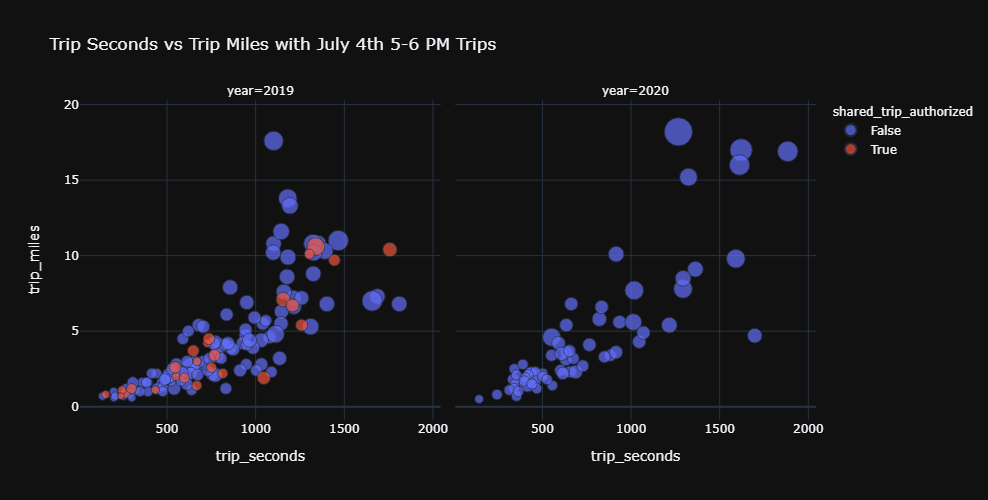

In [39]:
# YOUR CODE BEGINS
fig = px.scatter(
    df_july_fourth,
    title='Trip Seconds vs Trip Miles with July 4th 5-6 PM Trips',
    x='trip_seconds',
    y='trip_miles',
    size='trip_total',
    facet_col='year',
    color='shared_trip_authorized',
    template='plotly_dark',
    width=1200,
    height=500,
)
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [40]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-15"
did_pass = True
available_points = 5
message = ""

try:
    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguc2NhdHRlcigKICAgIGRmX2p1bHlf\
    Zm91cnRoX2NoZWNrLAogICAgdGl0bGU9J1RyaXAgU2Vjb25kcyB2cyBUcmlwIE1pbGVzIHdpdGggSnVseS\
    A0dGggNS02IFBNIFRyaXBzJywKICAgIHg9J3RyaXBfc2Vjb25kcycsCiAgICB5PSd0cmlwX21pbGVzJywK\
    ICAgIHNpemU9J3RyaXBfdG90YWwnLAogICAgZmFjZXRfY29sPSd5ZWFyJywKICAgIGNvbG9yPSdzaGFyZW\
    RfdHJpcF9hdXRob3JpemVkJywKICAgIHRlbXBsYXRlPSdwbG90bHlfZGFyaycsCiAgICB3aWR0aD0xMjAw\
    LAogICAgaGVpZ2h0PTUwMCwKKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))


    # DO NOT CHANGE THE CODE IN THIS CELL
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), len(fig_check.data), 
                   'Must use a facet grid to display two scatter plots side-by-side with color-encoding')
    tc.assertEqual(fig.layout.width, 1200, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 500, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    for i in range(len(fig_check.data)):
        tc.assertEqual(fig.data[i].type, 'scatter', 'Must be a scatter plot')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15'], 'student_score': 49, 'total_available': 49, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable

---

### 📌 Interpreting the pre-covid vs post-covid scatter plots

- 🔍 There is a positive linear relationship between `trip_seconds` and `trip_miles`.
- 🔍 The number of trips made on July 4th has decreased signifcantly in 2020 due to COVID-19.
- 🔍 There are no pooled trips (`shared_trips_authorized == True`) in 2020. 
    - Why? Uber and Lyft both suspended pooled rides to limit the spread of coronavirus ([Reuters article here](https://www.reuters.com/article/us-health-coronavirus-uber/uber-lyft-suspend-pooled-rides-in-u-s-canada-to-limit-spread-of-coronavirus-idUSKBN214192)) beginning in March 2020.

---

### 🎯 Deliverable 16: July 4th 5-6 PM trips 3D scatter plots (Pre-COVID)

#### 👇 Tasks

- ✔️ Using `df_july_fourth`, create a 3D scatter plot of trips **in 2019** using the following axes.
    - `x`: `trip_seconds`,
    - `y`: `trip_miles`,
    - `z`: `trip_total`
- ✔️ Use the `shared_trip_authorized` column to differente the colors of points.
- ✔️ Set an appropriate title.
- ✔️ Use the `'plotly_dark'` theme.
- ✔️ Set both the `width` and `height` to `800`.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/c3060e2ed215f9e7e13156b60a2c79764885f2c0/case-studies/rideshare-trips/sample-trip-seconds-vs-miles-vs-total-2019-3d-scatter-01.png?raw=true)

#### 🚀 Hint

Replace `'column1'`, `'column2'`, `'column3'`, `'column4'`, and `...`s with your own values from the code below.

```python
fig = px.scatter_3d(
    df_july_fourth[df_july_fourth['year'] == 2019],
    title='Your Title Here',
    x='column1',
    y='column2',
    z='column3',
    color='column4',
    template='plotly_dark',
    width=...,
    height=...
)
fig.show()
```

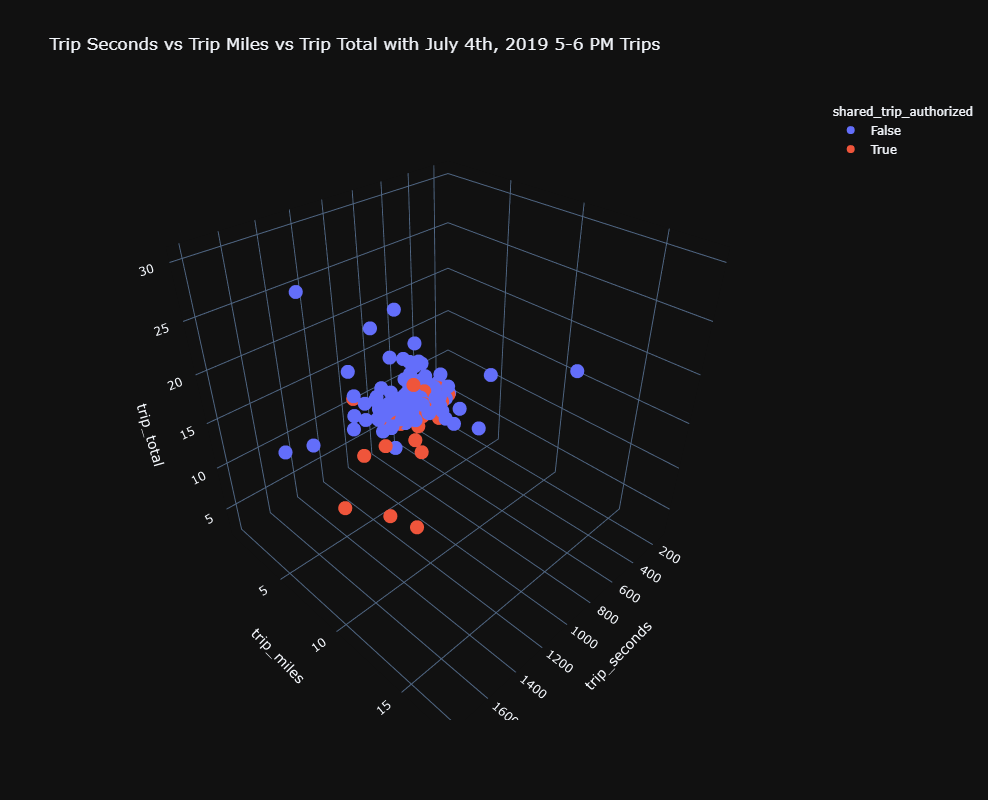

In [41]:
# YOUR CODE BEGINS
fig = px.scatter_3d(
    df_july_fourth[df_july_fourth['year'] == 2019],
    title='Trip Seconds vs Trip Miles vs Trip Total with July 4th, 2019 5-6 PM Trips',
    x='trip_seconds',
    y='trip_miles',
    z='trip_total',
    color='shared_trip_authorized',
    template='plotly_dark',
    width=800,
    height=800
)
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [42]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-16"
did_pass = True
available_points = 5
message = ""

try:
    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguc2NhdHRl\
    cl8zZCgKICAgIGRmX2p1bHlfZm91cnRoX2NoZWNrW2RmX2p1bHlfZm91cnRoX2\
    NoZWNrWyd5ZWFyJ10gPT0gMjAxOV0sCiAgICB0aXRsZT0nVHJpcCBTZWNvbmRz\
    IHZzIFRyaXAgTWlsZXMgdnMgVHJpcCBUb3RhbCB3aXRoIEp1bHkgNHRoLCAyMD\
    E5IDUtNiBQTSBUcmlwcycsCiAgICB4PSd0cmlwX3NlY29uZHMnLAogICAgeT0n\
    dHJpcF9taWxlcycsCiAgICB6PSd0cmlwX3RvdGFsJywKICAgIGNvbG9yPSdzaG\
    FyZWRfdHJpcF9hdXRob3JpemVkJywKICAgIHRlbXBsYXRlPSdwbG90bHlfZGFy\
    aycsCiAgICB3aWR0aD04MDAsCiAgICBoZWlnaHQ9ODAwCik=')
    eval(compile(decoded_code, '<string>', 'exec'))


    # DO NOT CHANGE THE CODE IN THIS CELL
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(len(fig.data), len(fig_check.data), "Check whether you've supplied the color parameter to px.scatter_3d()")
    tc.assertEqual(fig.layout.width, 800, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 800, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_dark'], 'Incorrect plotly theme (template)')

    for i in range(len(fig_check.data)):
        tc.assertEqual(fig.data[i].type, 'scatter3d', 'Must be a 3D scatter plot')

        np.testing.assert_array_equal(
            fig.data[i].x,
            fig_check.data[i].x,
            'x-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].y,
            fig_check.data[i].y,
            'y-axis value(s) mismatch'
        )

        np.testing.assert_array_equal(
            fig.data[i].z,
            fig_check.data[i].z,
            'z-axis value(s) mismatch'
        )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16'], 'student_score': 54, 'total_available': 54, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass': True, 'message':

▶️ Run the code cell below to repeat the previous deliverable with trips **in 2020**.

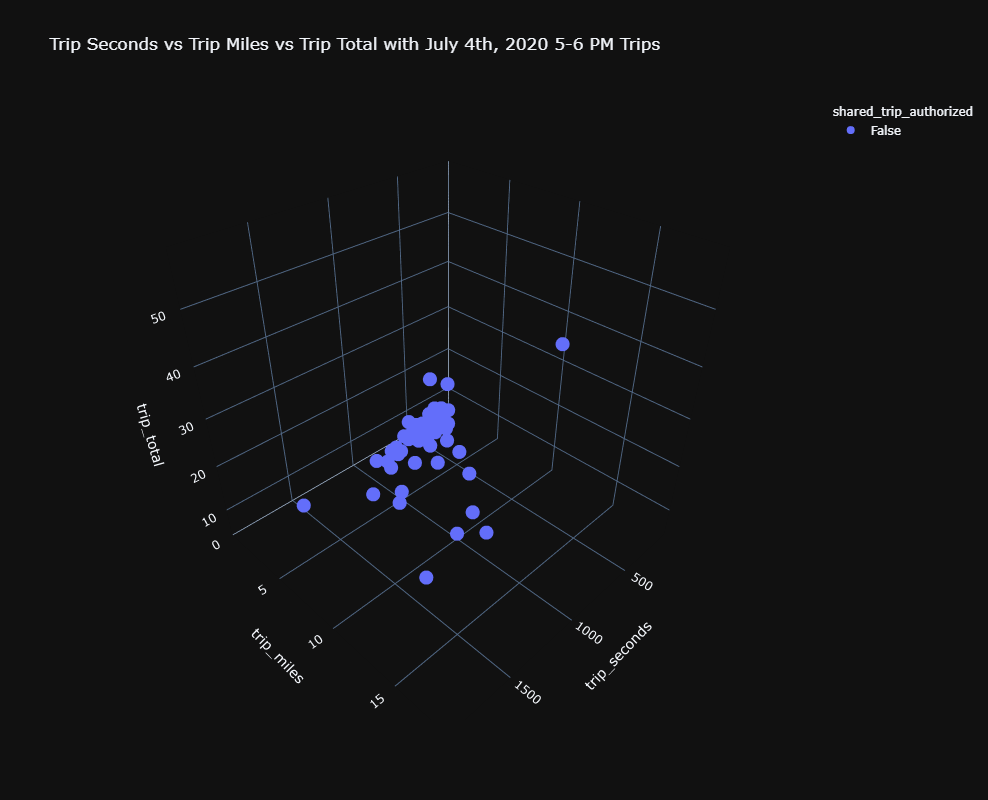

In [43]:
# DO NOT CHANGE THE CODE BELOW
fig = px.scatter_3d(
    df_july_fourth[df_july_fourth['year'] == 2020],
    title='Trip Seconds vs Trip Miles vs Trip Total with July 4th, 2020 5-6 PM Trips',
    x='trip_seconds',
    y='trip_miles',
    z='trip_total',
    color='shared_trip_authorized',
    template='plotly_dark',
    width=800,
    height=800
)
fig.show()

---

### 📌 Interpreting the pre-covid vs post-covid 3D scatter plots

- 🔍 There is a positive linear relationship between `trip_seconds`, `trip_miles`, and `trip_total`.
- 🔍 You may have to rotate the view of your 3D scatter plots to witness the linear relationships.

---

## 🏡 Part 6: Pickup/dropff area analysis

In this part, you will find the top 20 pickup areas and analyze the trips originating from those areas.

---

### 🎯 Deliverable 17: Find top 20 pickup areas by number of trips

#### 👇 Tasks

- ✔️ Find the top 20 pickup areas in `df_listings` by number of listings.
- ✔️ Store the result to a new variable named `top_20_pickup_areas`.
- ✔️ `top_20_pickup_areas` should be a Python `list` type.
- ✔️ We'll give you the fully-working code below.

#### 🔥 Solution

![Code](https://github.com/bdi475/images/blob/1923a8c4dff4775790bd333b285321f289334fbe/case-studies/rideshare-trips/code-find-top-20-pickup-areas-01.png?raw=true)

In [44]:
# YOUR CODE BEGINS
top_20_pickup_areas = df['pickup_area'].value_counts().head(20).index.tolist()
# YOUR CODE ENDS

print(top_20_pickup_areas)

['Near North Side', 'Loop', 'Near West Side', 'Lake View', 'West Town', 'Lincoln Park', 'Logan Square', 'Uptown', 'Ohare', 'Near South Side', 'Edgewater', 'Hyde Park', 'Lower West Side', 'North Center', 'Austin', 'Avondale', 'Lincoln Square', 'Rogers Park', 'Irving Park', 'South Shore']


#### 🧭 Check your work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [45]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-17"
did_pass = True
available_points = 2
message = ""

try:
    decoded_code = base64.b64decode(b'dG9wXzIwX3BpY2t1cF9hcmVhc19jaGVjayA9IGRmX2JhY\
    2t1cFsncGlja3VwX2FyZWEnXS52YWx1ZV9jb3VudHMoKS5oZWFkKDIwKS5pbmRleC50b2xpc3QoKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(set(top_20_pickup_areas), set(top_20_pickup_areas_check), 'Incorrect pickup areas')
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17'], 'student_score': 56, 'total_available': 56, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'points': 3, 'did_pass'

---

### 🎯 Deliverable 18: Filter trips from top 20 pickup areas

#### 👇 Tasks

- ✔️ Using `df`, filter only the rows where the `pickup_area` is in `top_20_pickup_areas`.
- ✔️ Store the filtered result to a new variable named `df_filtered`.

#### 🚀 Hint

```python
filtered_dataframe = my_dataframe[(my_dataframe['column1'].isin(my_top_10_list))]
```

In [46]:
# YOUR CODE BEGINS
df_filtered = df[(df['pickup_area'].isin(top_20_pickup_areas))]
# YOUR CODE ENDS

display(df_filtered.head(3))
print(f'There are {df_filtered.shape[0]} rows and {df_filtered.shape[1]} columns in the filtered DataFrame')

start  trip_seconds  trip_miles      pickup_area     dropoff_area  \
1 2019-01-01           697         3.0  Near North Side   Near West Side   
2 2019-01-01          1598         4.7     Lincoln Park             Loop   
3 2019-01-01           573         0.9  Near North Side  Near North Side   

   fare  tip  additional_charges  trip_total  shared_trip_authorized  \
1   7.5  0.0                 2.5        10.0                   False   
2  10.0  2.0                 2.5        14.5                   False   
3   5.0  0.0                 2.5         7.5                   False   

   trips_pooled  pickup_lat  pickup_lon  dropoff_lat  dropoff_lon  year  \
1             1   41.892073  -87.628874    41.885300   -87.642808  2019   
2             1   41.922083  -87.634156    41.870607   -87.622173  2019   
3             1   41.892042  -87.631864    41.892508   -87.626215  2019   

   month  day  dayofweek  hour weekday_weekend  
1      1    1          1     0         weekday  
2      1    1          1     0         weekday  
3      1    1          1     0         weekday

There are 1084442 rows and 21 columns in the filtered DataFrame


#### 🧭 Check your work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [47]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-18"
did_pass = True
available_points = 3
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfZmlsdGVyZWRfY2hlY2sgPSBkZl9iYWNrdXBbKGR\
    mX2JhY2t1cFsncGlja3VwX2FyZWEnXS5pc2luKHRvcF8yMF9waWNrdXBfYXJlYXNfY2hlY2spKV0=')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(df_filtered.shape, df_filtered_check.shape, 'Incorrect number of rows and/or columns')
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18'], 'student_score': 59, 'total_available': 59, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available_points': 3, 'poin

---

### 🎯 Deliverable 19: Number of trips and average trip total by pickup_area

#### 👇 Tasks

- ✔️ Using `df_filtered`, calculate the following aggregated values by `pickup_area`.
    - `num_trips`: Number of trips
    - `trip_total`: Average `trip_total`
- ✔️ Store the resulting DataFrame to a new variable named `df_by_pickup_area`.
- ✔️ We'll give you the fully-working code below.

#### 🔥 Solution

![Code](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/code-agg-by-pickup-area-01.png?raw=true)

In [48]:
# YOUR CODE BEGINS
df_by_pickup_area = df_filtered.groupby(
    'pickup_area', as_index=False
).agg({
    'start': 'count',
    'trip_total': 'mean',
}).rename(columns={
    'start': 'num_trips'
})
# YOUR CODE ENDS

display(df_by_pickup_area.head(5))

pickup_area  num_trips  trip_total
0       Austin      16851   13.246273
1     Avondale      16425   12.623803
2    Edgewater      21689   13.867470
3    Hyde Park      21303   14.523999
4  Irving Park      14570   13.326660

#### 🧭 Check your work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [49]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-19"
did_pass = True
available_points = 2
message = ""

try:
    decoded_code = base64.b64decode(b'ZGZfYnlfcGlja3VwX2FyZWFfY2hlY2sgPSBkZl9maWx0Z\
    XJlZF9jaGVjay5ncm91cGJ5KAogICAgJ3BpY2t1cF9hcmVhJywgYXNfaW5kZXg9RmFsc2UKKS5hZ2co\
    ewogICAgJ3N0YXJ0JzogJ2NvdW50JywKICAgICd0cmlwX3RvdGFsJzogJ21lYW4nLAp9KS5yZW5hbWU\
    oY29sdW1ucz17CiAgICAnc3RhcnQnOiAnbnVtX3RyaXBzJwp9KQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(
        df_by_pickup_area.shape,
        df_by_pickup_area_check.shape,
        'Incorrect number of rows and/or columns'
    )
    pd.testing.assert_frame_equal(
        df_by_pickup_area.sort_values(df_by_pickup_area.columns.tolist()).reset_index(drop=True),
        df_by_pickup_area_check.sort_values(df_by_pickup_area_check.columns.tolist()).reset_index(drop=True),
        check_like=True
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19'], 'student_score': 61, 'total_available': 61, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverable-07': {'available

---

### 🎯 Deliverable 20: Number of trips by pickup area (bar chart)

#### 👇 Tasks

- ✔️ Using `df_by_pickup_area`, create a horizontal bar chart displaying the number of trips by each pickup area.
- ✔️ Set an appropriate title.
- ✔️ Set the height to `800` and do not supply a width (by default, a Plotly figure will expand to fit the window if the `width` parameter is omitted).
- ✔️ Use the `plotly_white` template.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/sample-num-trips-by-pickup-area-bar-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, and `...`s with your own values from the code below.

```python
fig = px.bar(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    color='column1',
    color_continuous_scale='emrld',
    text='column1',
    template='plotly_white',
    height=...
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_yaxes(categoryorder='total ascending')
fig.show()
```

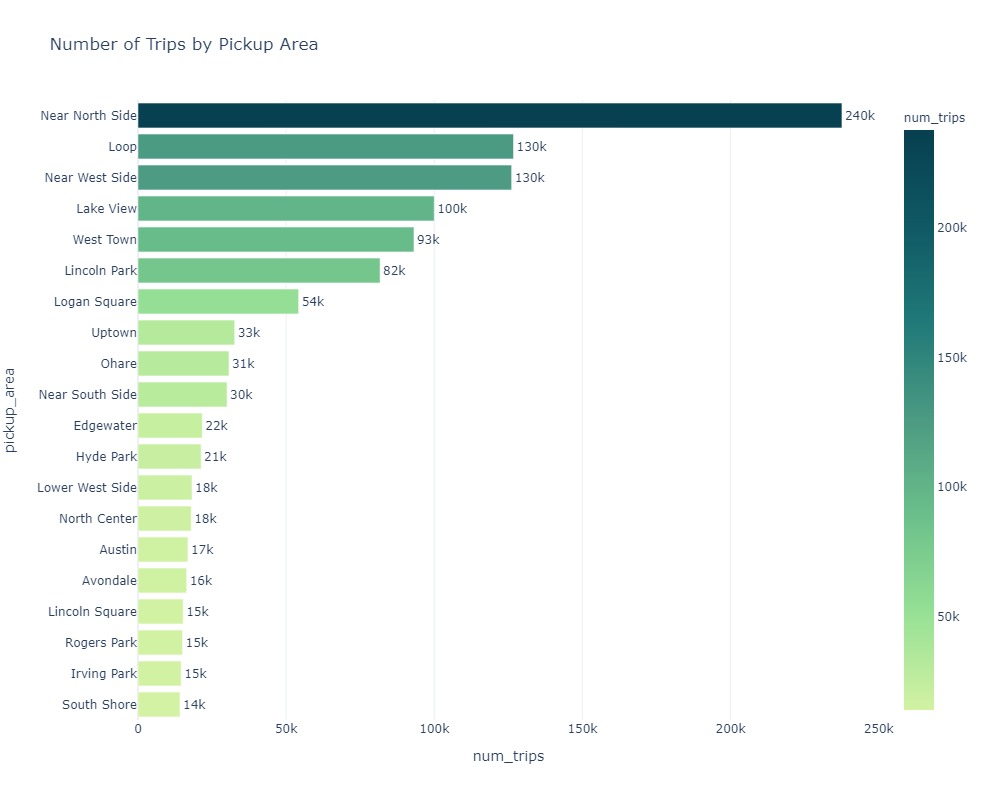

In [50]:
# YOUR CODE BEGINS
fig = px.bar(
    df_by_pickup_area,
    title='Number of Trips by Pickup Area',
    x='num_trips',
    y='pickup_area',
    color='num_trips',
    color_continuous_scale='emrld',
    text='num_trips',
    template='plotly_white',
    height=800
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_yaxes(categoryorder='total ascending')
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [51]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-20"
did_pass = True
available_points = 5
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(fig.layout.height, 800, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_white'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguYmFyKAog\
    ICAgZGZfYnlfcGlja3VwX2FyZWFfY2hlY2ssCiAgICB0aXRsZT0nTnVtYmVyIG\
    9mIFRyaXBzIGJ5IFBpY2t1cCBBcmVhJywKICAgIHg9J251bV90cmlwcycsCiAg\
    ICB5PSdwaWNrdXBfYXJlYScsCiAgICBjb2xvcj0nbnVtX3RyaXBzJywKICAgIG\
    NvbG9yX2NvbnRpbnVvdXNfc2NhbGU9J2VtcmxkJywKICAgIHRleHQ9J251bV90\
    cmlwcycsCiAgICB0ZW1wbGF0ZT0ncGxvdGx5X3doaXRlJywKICAgIGhlaWdodD04MDAKKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(fig.data[0].type, 'bar', 'Must be a line plot')

    np.testing.assert_array_equal(
        fig.data[0].x,
        fig_check.data[0].x,
        'x-axis value(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].y,
        fig_check.data[0].y,
        'y-axis value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19', 'deliverable-20'], 'student_score': 66, 'total_available': 66, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message': ''}, 'deliverabl

---

### 🎯 Deliverable 21: Average trip total by pickup area (bar chart)

#### 👇 Tasks

- ✔️ Using `df_by_pickup_area`, create a horizontal bar chart displaying the average trip total by each pickup area.
- ✔️ Set an appropriate title.
- ✔️ Set the height to `800` and do not supply a width (by default, a Plotly figure will expand to fit the window if the `width` parameter is omitted).
- ✔️ Use the `plotly_white` template.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/sample-avg-trip-total-by-pickup-area-bar-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, `'column2'`, and `...`s with your own values from the code below.

```python
fig = px.bar(
    my_dataframe,
    title='Your Title Here',
    x='column1',
    y='column2',
    text='column1',
    template='plotly_white',
    height=...
)
fig.update_traces(texttemplate='$%{text:.1f}', textposition='outside')
fig.update_yaxes(categoryorder='total ascending')
fig.show()
```

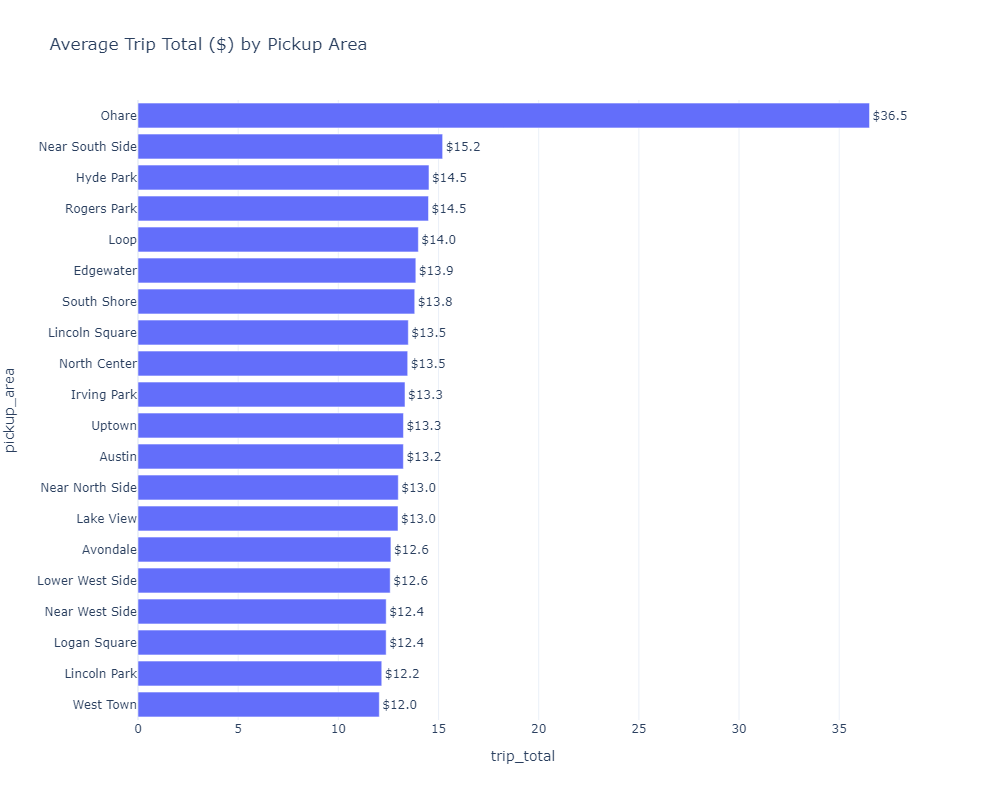

In [52]:
# YOUR CODE BEGINS
fig = px.bar(
    df_by_pickup_area,
    title='Average Trip Total ($) by Pickup Area',
    x='trip_total',
    y='pickup_area',
    text='trip_total',
    template='plotly_white',
    height=800
)
fig.update_traces(texttemplate='$%{text:.1f}', textposition='outside')
fig.update_yaxes(categoryorder='total ascending')
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [53]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-21"
did_pass = True
available_points = 5
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(fig.layout.height, 800, 'Incorrect height')
    tc.assertEqual(fig.layout.template, pio.templates['plotly_white'], 'Incorrect plotly theme (template)')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguYmFyKAogICAg\
    ZGZfYnlfcGlja3VwX2FyZWFfY2hlY2ssCiAgICB0aXRsZT0nQXZlcmFnZSBUcmlwIF\
    RvdGFsICgkKSBieSBQaWNrdXAgQXJlYScsCiAgICB4PSd0cmlwX3RvdGFsJywKICAg\
    IHk9J3BpY2t1cF9hcmVhJywKICAgIHRleHQ9J3RyaXBfdG90YWwnLAogICAgdGVtcG\
    xhdGU9J3Bsb3RseV93aGl0ZScsCiAgICBoZWlnaHQ9ODAwCik=')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(fig.data[0].type, 'bar', 'Must be a line plot')

    np.testing.assert_array_equal(
        fig.data[0].x,
        fig_check.data[0].x,
        'x-axis value(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].y,
        fig_check.data[0].y,
        'y-axis value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19', 'deliverable-20', 'deliverable-21'], 'student_score': 71, 'total_available': 71, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass': True, 'message'

---

### 🎯 Deliverable 22: Pickup area breakdown (treemap)

#### 👇 Tasks

- ✔️ Using `df_by_pickup_area`, create a treemap of pickup areas.
- ✔️ Set an appropriate title.
- ✔️ Store your figure to a variable named `fig`.
- ✔️ Display the figure using `fig.show()`

#### 🔑 Sample Output

![Sample Output](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/sample-pickup-area-treemap-01.png?raw=true)

#### 🚀 Hint

Replace `my_dataframe`, `'column1'`, and `'column2'` with your own values from the code below.

```python
fig = px.treemap(
    my_dataframe,
    title='Pickup Area Breakdown',
    path=['column1'],
    values='column2',
    height=600
)
fig.show()
```

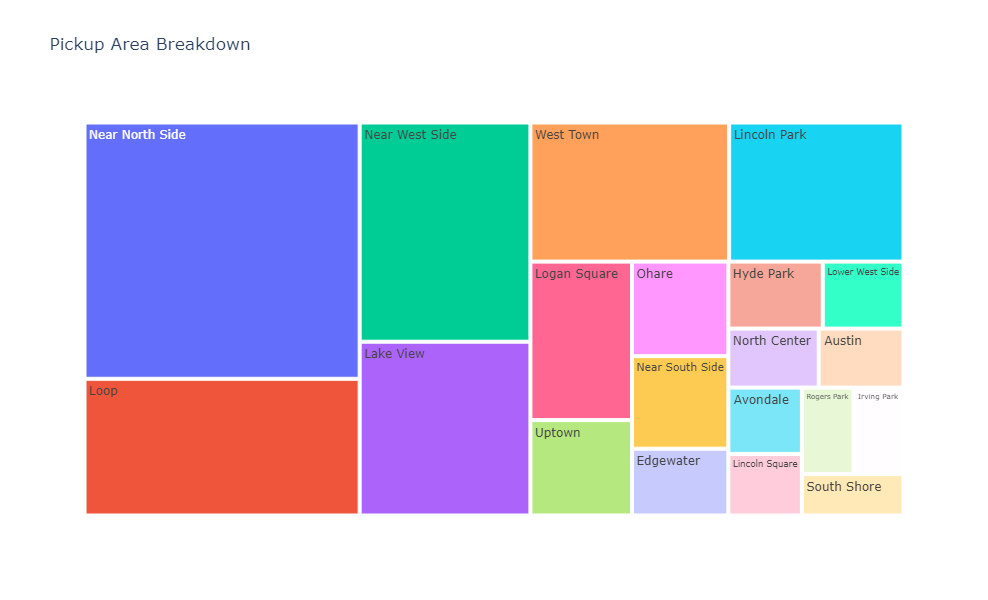

In [54]:
# YOUR CODE BEGINS
fig = px.treemap(
    df_by_pickup_area,
    title='Pickup Area Breakdown',
    path=['pickup_area'],
    values='num_trips',
    height=600
)
fig.show()
# YOUR CODE ENDS

#### 🧭 Check Your Work

- Once you're done, run the code cell below to test correctness.
- ✔️ If the code cell runs without an error, you're good to move on.
- ❌ If the code cell throws an error, go back and fix incorrect parts.

In [55]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-22"
did_pass = True
available_points = 5
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHgudHJlZW1hcCg\
    KICAgIGRmX2J5X3BpY2t1cF9hcmVhX2NoZWNrLAogICAgdGl0bGU9J1BpY2t1cCBB\
    cmVhIEJyZWFrZG93bicsCiAgICBwYXRoPVsncGlja3VwX2FyZWEnXSwKICAgIHZhb\
    HVlcz0nbnVtX3RyaXBzJywKICAgIGhlaWdodD02MDAKKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    tc.assertEqual(fig.data[0].type, 'treemap', 'Must be a treemap')

    np.testing.assert_array_equal(
        fig.data[0].labels,
        fig_check.data[0].labels,
        'Label value(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].parents,
        fig_check.data[0].parents,
        'Parent value(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].values,
        fig_check.data[0].values,
        'Size value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19', 'deliverable-20', 'deliverable-21', 'deliverable-22'], 'student_score': 76, 'total_available': 76, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'points': 3, 'did_pass

---

### 📌 Interpreting the pickup area visualizations

- 🔍 "Near North Side" is the most popular pickup area, followed by "Loop" and "Near West Side".
- 🔍 The average trip total for rides beginning in Ohare is relatively much higher compared to any other pickup area.

---

## 🦄 Part 7: Pickup area + weekday/weekend

In this part, you will add a new dimension (weekday/weekend) to the top 20 pickup areas.

▶️ Run the code cell below to create the number of trips and average trip totals by pickup area and weekday/weekend classification.

In [56]:
# DO NOT CHANGE THE CODE BELOW
df_by_pickup_area_weekday_weekend = df_filtered.groupby(
    ['pickup_area', 'weekday_weekend'], as_index=False
).agg({
    'start': 'count',
    'trip_total': 'mean',
}).rename(columns={
    'start': 'num_trips'
})

display(df_by_pickup_area_weekday_weekend.head(5))

pickup_area weekday_weekend  num_trips  trip_total
0      Austin         weekday       9064   13.213864
1      Austin         weekend       7787   13.283996
2    Avondale         weekday       7942   12.617546
3    Avondale         weekend       8483   12.629662
4   Edgewater         weekday      10745   14.131752

---

### 🎯 Deliverable 23: Pickup area + weekday/weekend breakdown (sunburst)

#### 👇 Tasks

- ✔️ Copy the code below to create a sunburst chart of number of trips by pickup area + weekday/weekend

#### 🔥 Solution

![Code](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/code-pickup-area-weekday-weekend-sunburst-01.png?raw=true)

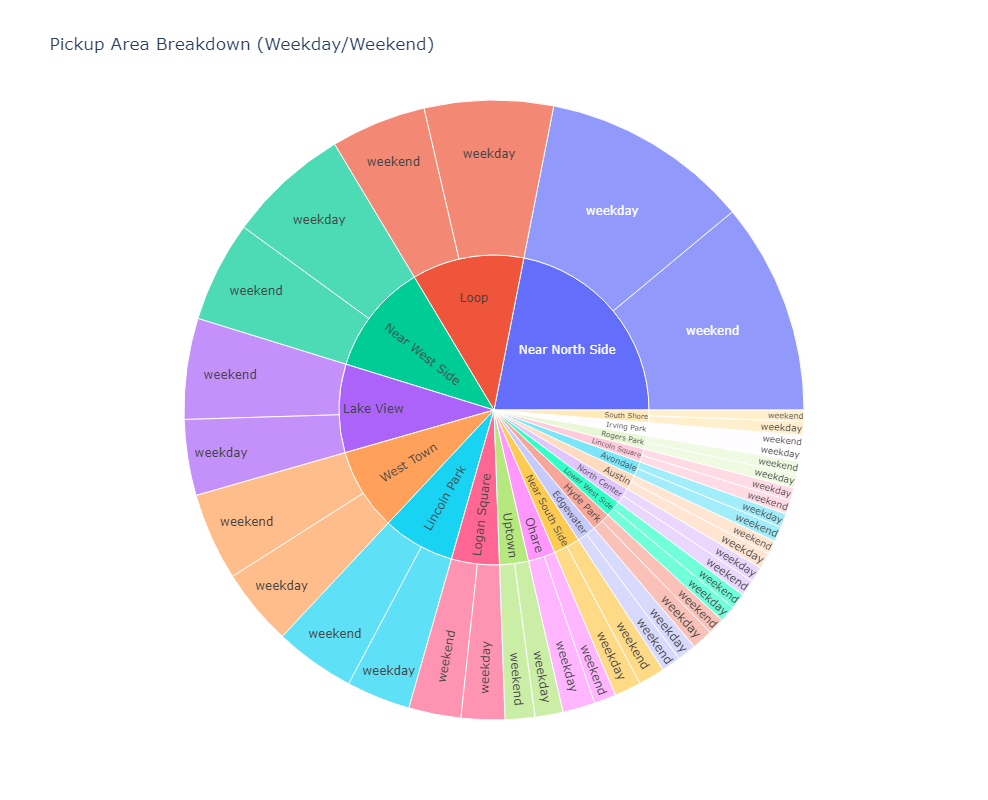

In [57]:
# YOUR CODE BEGINS
fig = px.sunburst(
    df_by_pickup_area_weekday_weekend,
    path=['pickup_area', 'weekday_weekend'],
    values='num_trips',
    title='Pickup Area Breakdown (Weekday/Weekend)',
    width=800,
    height=800
)
fig.show()
# YOUR CODE ENDS

In [58]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-23"
did_pass = True
available_points = 2
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(fig.data[0].type, 'sunburst', 'Must be a sunburst chart')
    tc.assertEqual(fig.layout.width, 800, 'Incorrect width')
    tc.assertEqual(fig.layout.height, 800, 'Incorrect height')

    decoded_code = base64.b64decode(b'ZmlnX2NoZWNrID0gcHguc3VuYnVyc3\
    QoCiAgICBkZl9ieV9waWNrdXBfYXJlYV93ZWVrZGF5X3dlZWtlbmQsCiAgICBwYX\
    RoPVsncGlja3VwX2FyZWEnLCAnd2Vla2RheV93ZWVrZW5kJ10sCiAgICB2YWx1ZX\
    M9J251bV90cmlwcycsCiAgICB0aXRsZT0nUGlja3VwIEFyZWEgQnJlYWtkb3duIC\
    hXZWVrZGF5L1dlZWtlbmQpJywKICAgIHdpZHRoPTgwMCwKICAgIGhlaWdodD04MDAKKQ==')
    eval(compile(decoded_code, '<string>', 'exec'))

    np.testing.assert_array_equal(
        fig.data[0].labels,
        fig_check.data[0].labels,
        'Label(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].parents,
        fig_check.data[0].parents,
        'Parent(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].values,
        fig_check.data[0].values,
        'Value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19', 'deliverable-20', 'deliverable-21', 'deliverable-22', 'deliverable-23'], 'student_score': 78, 'total_available': 78, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'available_points': 3, 'poi

---

### 🎯 Deliverable 24: Pickup area + weekday/weekend breakdown (treemap)

#### 👇 Tasks

- ✔️ Copy the code below to create a treemap chart of number of trips by pickup area + weekday/weekend

#### 🔥 Solution

![Code](https://github.com/bdi475/images/blob/main/case-studies/rideshare-trips/code-pickup-area-weekday-weekend-treemap-01.png?raw=true)

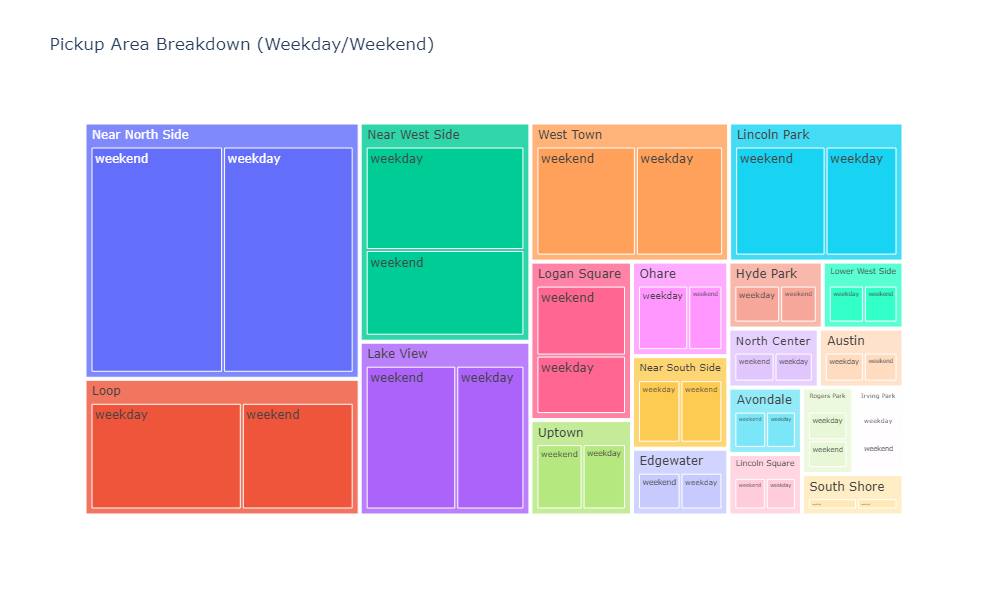

In [59]:
# YOUR CODE BEGINS
fig = px.treemap(
    df_by_pickup_area_weekday_weekend,
    path=['pickup_area', 'weekday_weekend'],
    values='num_trips',
    title='Pickup Area Breakdown (Weekday/Weekend)',
    height=600
)
fig.show()
# YOUR CODE ENDS

In [60]:
# DO NOT CHANGE THE CODE IN THIS CELL
part_name = "deliverable-24"
did_pass = True
available_points = 2
message = ""

try:
    tc.assertIsNotNone(fig.layout.title.text, 'Missing figure title')
    tc.assertEqual(fig.data[0].type, 'treemap', 'Must be a treemap chart')
    tc.assertEqual(fig.layout.height, 600, 'Incorrect height')

    decoded_code = base64.b64decode(b'ZmlnID0gcHgudHJlZW1hcCgKICAgIGRm\
    X2J5X3BpY2t1cF9hcmVhX3dlZWtkYXlfd2Vla2VuZCwKICAgIHBhdGg9WydwaWNrdX\
    BfYXJlYScsICd3ZWVrZGF5X3dlZWtlbmQnXSwKICAgIHZhbHVlcz0nbnVtX3RyaXBz\
    JywKICAgIHRpdGxlPSdQaWNrdXAgQXJlYSBCcmVha2Rvd24gKFdlZWtkYXkvV2Vla2\
    VuZCknLAogICAgaGVpZ2h0PTYwMAop')
    eval(compile(decoded_code, '<string>', 'exec'))

    np.testing.assert_array_equal(
        fig.data[0].labels,
        fig_check.data[0].labels,
        'Label(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].parents,
        fig_check.data[0].parents,
        'Parent(s) mismatch'
    )

    np.testing.assert_array_equal(
        fig.data[0].values,
        fig_check.data[0].values,
        'Value(s) mismatch'
    )
except Exception as err:
    did_pass = False
    message = err
    
    if not is_autograder_env:
        raise err
finally:
    if is_autograder_env:
        record_part(part_name, did_pass, available_points, message)

{'netid': 'grader_netid', 'order': ['deliverable-01', 'deliverable-02', 'deliverable-03', 'deliverable-04', 'deliverable-05', 'deliverable-06', 'deliverable-07', 'deliverable-08', 'deliverable-09', 'deliverable-10', 'deliverable-11', 'deliverable-12', 'deliverable-13', 'deliverable-14', 'deliverable-15', 'deliverable-16', 'deliverable-17', 'deliverable-18', 'deliverable-19', 'deliverable-20', 'deliverable-21', 'deliverable-22', 'deliverable-23', 'deliverable-24'], 'student_score': 80, 'total_available': 80, 'breakdown': {'deliverable-01': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-02': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-03': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-04': {'available_points': 2, 'points': 2, 'did_pass': True, 'message': ''}, 'deliverable-05': {'available_points': 4, 'points': 4, 'did_pass': True, 'message': ''}, 'deliverable-06': {'availabl

---

## 🍸 Submitting your notebook


There is one final step before exporting the notebook as an `.ipynb` file for submission. You should restart your runtime (kernal) and run all cells from the beginning to ensure that your notebook is structured properly.

Go to the **"Runtime"** ("Kernel" if you're on Jupyter Lab) menu on top. Select **"Restart and run all"**. Failing to pass this step may result in significant loss of points since the autograder will fail to run.<br /><br />

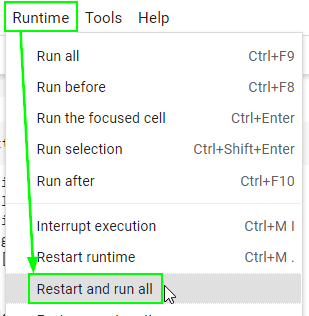

In [61]:
print('🎯 Restart and run all successful')

🎯 Restart and run all successful


In [62]:
# GRADER_ONLY
import os
from datetime import datetime
autograder_output_filename = f"{assignment_name}-autograder-results.csv"

netid = autograded_result["netid"]
assignment_name = autograded_result["assignment_name"]
student_score = autograded_result["student_score"]
total_available = autograded_result["total_available"]
graded_time = datetime.now().strftime("%Y-%m-%d %H:%M")
feedback = '''Assignment: {0}
NetID: {1}
Total Score: {2}/{3}

Grade Breakdown'''.format(assignment_name, netid, student_score, total_available)

for graded_part_name in autograded_result["order"]:
    part_info = autograded_result["breakdown"][graded_part_name]
    feedback += '''
--------------------------------
Component: {0}
Result: {1}
Score: {2}/{3}'''.format(graded_part_name, "Pass" if part_info["did_pass"] else "Fail", part_info["points"], part_info["available_points"])

    feedback += "" if part_info["did_pass"] else f"\nError Message: {part_info['message']}"

if is_autograder_env:
    df_agr_new = pd.DataFrame([{
        "netid": netid,
        "assignment_name": assignment_name,
        "student_score": student_score,
        "total_available": total_available,
        "graded_time": graded_time,
        "feedback": feedback
    }])
    
    if not os.path.exists(autograder_output_filename):
        df_agr = df_agr_new
    else:
        df_agr = pd.read_csv(autograder_output_filename)
        df_agr = df_agr.loc[~((df_agr["netid"] == netid) & (df_agr["assignment_name"] == assignment_name))]
        df_agr = pd.concat([df_agr, df_agr_new])
        
    df_agr.sort_values("graded_time").to_csv(autograder_output_filename, index=None)